# DATA 101 — Model Evaluation & Generalization (Session 3)

This notebook is self-contained:
- Creates an Advertising-like dataset if `Advertising.csv` is not present.
- Shows train/test split, R²/MAE/RMSE on test data.
- Demonstrates 5-fold cross-validation.
- Compares simple vs complex models using test metrics.

## 0. Setup

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

import statsmodels.api as sm

print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("matplotlib:", plt.matplotlib.__version__)
print("statsmodels:", sm.__version__)

numpy: 2.3.1
pandas: 2.3.1
matplotlib: 3.10.3
statsmodels: 0.14.5


## 1. Load data or create a realistic synthetic dataset

In [2]:
csv_path = "./data/Advertising.csv"

if os.path.exists(csv_path):
    df = pd.read_csv(csv_path)
else:
    rng = np.random.default_rng(2025)
    n = 200
    TV = rng.uniform(0, 300, n)
    Radio = rng.uniform(0, 50, n)
    Newspaper = rng.uniform(0, 100, n)
    Sales = 3.0 + 0.045*TV + 0.18*Radio + 0.01*Newspaper + rng.normal(0, 1.2, n)
    df = pd.DataFrame({"TV": TV, "Radio": Radio, "Newspaper": Newspaper, "Sales": Sales})
    df.to_csv(csv_path, index=False)

df.head()

,TV,Radio,Newspaper,Sales
0,283.059752,22.400382,13.046499,20.792160
1,107.826310,17.833197,17.377088,10.954803
2,235.441624,8.592322,25.762048,16.113905
3,177.383456,34.092156,92.782412,16.974606
4,88.298568,44.342255,80.859978,15.688330


## 2. Train/Test Split (reproducible)

In [3]:
X = df[["TV","Radio","Newspaper"]].values
y = df["Sales"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42
)

model_train = sm.OLS(y_train, sm.add_constant(X_train)).fit()
y_pred_test = model_train.predict(sm.add_constant(X_test))

print(model_train.summary().tables[0])

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                     604.6
Date:                Fri, 24 Oct 2025   Prob (F-statistic):           2.08e-78
Time:                        14:00:03   Log-Likelihood:                -232.45
No. Observations:                 140   AIC:                             472.9
Df Residuals:                     136   BIC:                             484.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         


## 3. Evaluate Predictions on Test Data

Test R^2:  0.923
Test MAE:  1.092
Test RMSE: 1.332


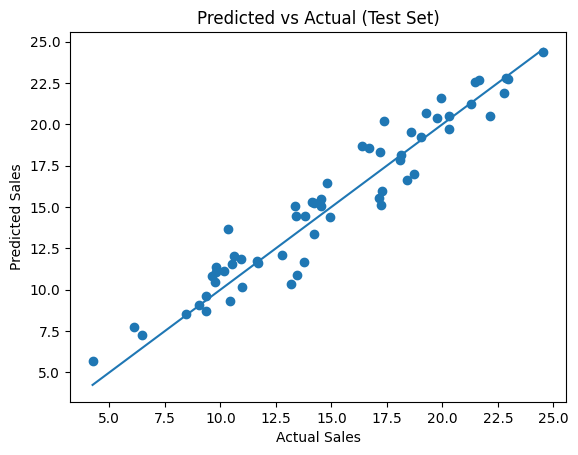

In [4]:
r2_test = r2_score(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_test = root_mean_squared_error(y_test, y_pred_test)

print(f"Test R^2:  {r2_test:.3f}")
print(f"Test MAE:  {mae_test:.3f}")
print(f"Test RMSE: {rmse_test:.3f}")

plt.figure()
plt.scatter(y_test, y_pred_test)
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("Predicted vs Actual (Test Set)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()])
plt.show()

Interpretation of results:

* **Test (R^2 = 0.923):**
  The model explains about **92.3% of the variation** in sales for **unseen (test) data**.
  This indicates a **strong predictive relationship** — the model generalizes well.

* **Test MAE = 1.09:**
  On average, the model’s predictions are **off by about 1.1 sales units** from the actual values, regardless of direction.
  (MAE measures the *typical absolute prediction error*.)

* **Test RMSE = 1.33:**
  The model’s **root mean squared error** is about **1.33 sales units**, meaning that most predictions fall within roughly ±1.3 of the true sales values.
  RMSE gives more weight to larger errors, so it’s slightly higher than MAE.

**Summary interpretation:**

> The model performs well on new data — it explains over 90% of the sales variation and typically predicts sales within **about 1 to 1.3 units** of the actual value.
> Errors are small relative to the sales range, suggesting **strong and reliable generalization**.

## 4. 5-Fold Cross-Validation (R²)

In [5]:
lin = LinearRegression()
cv_scores = cross_val_score(lin, X, y, cv=5, scoring='r2')
print("Fold R^2 scores:", np.round(cv_scores, 3))
print("Average Cross-Validated R^2:", np.round(cv_scores.mean(), 3))

Fold R^2 scores: [0.929 0.933 0.875 0.928 0.928]
Average Cross-Validated R^2: 0.919


## 5. Comparing Models on the Same Split

In [6]:
def test_metrics(Xtr, Xte, ytr, yte):
    mdl = sm.OLS(ytr, sm.add_constant(Xtr)).fit()
    pred_tr = mdl.predict(sm.add_constant(Xtr))
    pred_te = mdl.predict(sm.add_constant(Xte))
    return (
        r2_score(ytr, pred_tr), 
        r2_score(yte, pred_te), 
        root_mean_squared_error(yte, pred_te)
    )

X = df[["TV","Radio","Newspaper"]].values
y = df["Sales"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

tr_r2_s, te_r2_s, te_rmse_s = test_metrics(X_train[:, [0]], X_test[:, [0]], y_train, y_test)
tr_r2_r, te_r2_r, te_rmse_r = test_metrics(X_train[:, [0,1]], X_test[:, [0,1]], y_train, y_test)
tr_r2_f, te_r2_f, te_rmse_f = test_metrics(X_train, X_test, y_train, y_test)

cmp = pd.DataFrame({
    "Model": ["Simple (TV)", "Reduced (TV+Radio)", "Full (TV+Radio+News)"],
    "Train_R2": np.round([tr_r2_s, tr_r2_r, tr_r2_f], 3),
    "Test_R2": np.round([te_r2_s, te_r2_r, te_r2_f], 3),
    "Test_RMSE": np.round([te_rmse_s, te_rmse_r, te_rmse_f], 3),
    "Complexity": ["Low", "Medium", "Higher"]
})
cmp

,Model,Train_R2,Test_R2,Test_RMSE,Complexity
0,Simple (TV),0.620,0.585,3.087,Low
1,Reduced (TV+Radio),0.929,0.919,1.362,Medium
2,Full (TV+Radio+News),0.930,0.923,1.332,Higher
